In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow.keras.backend import clear_session, sigmoid
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.layers import Activation, Dense, Dropout
from keras.models import Sequential

In [2]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    # plt.style.use('ggplot')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [3]:
SEED = 100

dim = 600
# base_vetorizada = "base_vetorizada"
base_vetorizada = "s3_base_vetorizada_600"

pasta = "bases_treino_teste"
arquivo1 = "tratado_links_folha_rotulados_base_estigma_resgatados.csv"
arquivo2 = "tratado_links_estadao_rotulados_base_estigma_resgatados.csv"
arquivo3 = "tratado_links_estadao_rotulados_resgatados.csv"

In [4]:
df1 = pd.read_csv(f"{base_vetorizada}/{pasta}/{arquivo1}")
df2 = pd.read_csv(f"{base_vetorizada}/{pasta}/{arquivo2}")
df3 = pd.read_csv(f"{base_vetorizada}/{pasta}/{arquivo3}")

In [5]:
vetor1 = np.load(f"{base_vetorizada}/{pasta}/{arquivo1}.npy")
vetor2 = np.load(f"{base_vetorizada}/{pasta}/{arquivo2}.npy")
vetor3 = np.load(f"{base_vetorizada}/{pasta}/{arquivo3}.npy")

In [6]:
df3.shape

(103, 6)

In [7]:
df_y = pd.concat([
    df1[["metaforico"]],
    df2[["metaforico"]]
    # df3[["metaforico"]]
], axis = 0)

df_y.shape

(1533, 1)

In [8]:
# vetor_x = np.concatenate((vetor1, vetor2, vetor3), axis = 0)
vetor_x = np.concatenate((vetor1, vetor2), axis = 0)
vetor_x.shape

(1533, 600)

In [9]:
X = vetor_x 
y = df_y["metaforico"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state = SEED)

In [11]:
print("Dados de treino = ", X_train.shape)
print("Dados de teste = ", X_test.shape)

Dados de treino =  (1226, 600)
Dados de teste =  (307, 600)


In [12]:
print("Proporção de y de treino")
print(y_train.value_counts(normalize = True))

print("\nProporção de y de teste")
print(y_test.value_counts(normalize = True))

Proporção de y de treino
0    0.659054
1    0.340946
Name: metaforico, dtype: float64

Proporção de y de teste
0    0.65798
1    0.34202
Name: metaforico, dtype: float64


In [13]:
tf.keras.backend.clear_session()

In [14]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

In [15]:
opt = SGD(learning_rate = 0.001, nesterov = True)

# def swish(x, beta = 1):
#     return (x * sigmoid(beta * x))
# get_custom_objects().update({'swish': Activation(swish)})  

class Swish(Activation):
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'
        
def swish(x):
    return (sigmoid(x) * x)
get_custom_objects().update({'swish': Swish(swish)})

In [16]:
model_cbow = Sequential()
model_cbow.add(Dense(512, input_dim=dim, activation='swish'))
model_cbow.add(Dropout(0.2))
model_cbow.add(Dense(256, activation='swish'))
model_cbow.add(Dropout(0.2))
model_cbow.add(Dense(128, activation='swish'))
model_cbow.add(Dropout(0.2))
model_cbow.add(Dense(64, activation='swish'))
model_cbow.add(Dense(1, activation='sigmoid'))
model_cbow.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_cbow.summary()

# model_cbow = Sequential()
# model_cbow.add(Dense(1024, input_dim=dim, activation='swish'))
# model_cbow.add(Dropout(0.2))
# model_cbow.add(Dense(1024, activation='swish'))
# model_cbow.add(Dropout(0.2))
# model_cbow.add(Dense(512, activation='swish'))
# model_cbow.add(Dropout(0.2))
# model_cbow.add(Dense(256, activation='swish'))
# model_cbow.add(Dropout(0.1))
# model_cbow.add(Dense(64, activation='swish'))
# model_cbow.add(Dense(1, activation='sigmoid'))
# model_cbow.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])
# model_cbow.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               307712    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [17]:
history_cbow = model_cbow.fit(X_train, y_train, 
                              epochs=100, 
                              validation_data=(X_test, y_test), 
                              batch_size=10,
                              callbacks = [callback])

Epoch 1/100
123/123 [==============================] - 2s 8ms/step - loss: 0.7085 - accuracy: 0.6175 - val_loss: 0.6420 - val_accuracy: 0.7166
Epoch 2/100
123/123 [==============================] - 1s 7ms/step - loss: 0.6399 - accuracy: 0.6762 - val_loss: 0.5887 - val_accuracy: 0.7948
Epoch 3/100
123/123 [==============================] - 1s 5ms/step - loss: 0.6003 - accuracy: 0.7463 - val_loss: 0.5378 - val_accuracy: 0.7948
Epoch 4/100
123/123 [==============================] - 1s 5ms/step - loss: 0.5410 - accuracy: 0.7798 - val_loss: 0.4925 - val_accuracy: 0.8208
Epoch 5/100
123/123 [==============================] - 1s 5ms/step - loss: 0.4940 - accuracy: 0.8067 - val_loss: 0.4528 - val_accuracy: 0.8339
Epoch 6/100
123/123 [==============================] - 1s 6ms/step - loss: 0.4668 - accuracy: 0.8132 - val_loss: 0.4215 - val_accuracy: 0.8371
Epoch 7/100
123/123 [==============================] - 1s 6ms/step - loss: 0.4508 - accuracy: 0.8287 - val_loss: 0.3814 - val_accuracy: 0.8339

In [18]:
loss_cbow, accuracy_cbow = model_cbow.evaluate(X_test, y_test, verbose=False)
print("perda (erro) = ", loss_cbow)
print()
print("Acurácia = ",  accuracy_cbow)

perda (erro) =  0.22818033397197723

Acurácia =  0.9153094291687012


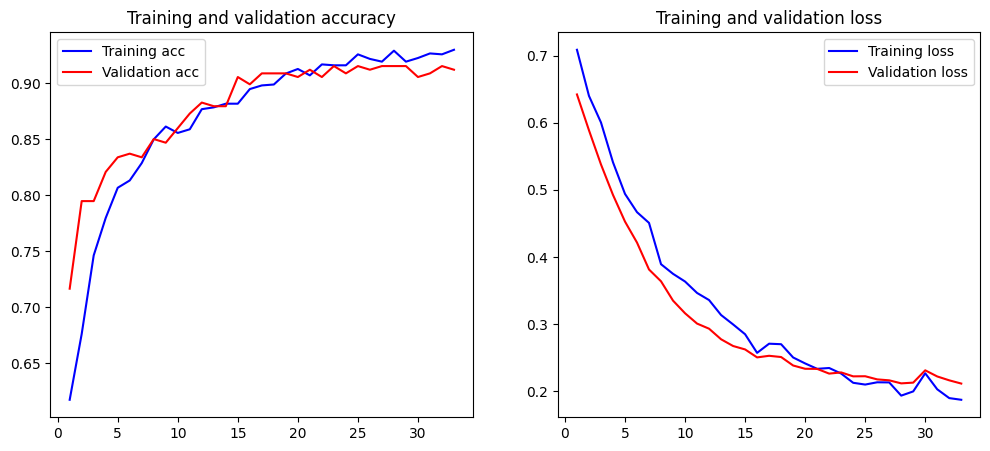

In [19]:
plot_history(history_cbow)

In [20]:
y_predict = (model_cbow.predict(X_test) > 0.5).astype("int32")

10/10 [==============================] - 0s 2ms/step


In [21]:
y_pred = [x[0] for x in y_predict]

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       202
           1       0.92      0.83      0.87       105

    accuracy                           0.92       307
   macro avg       0.92      0.89      0.90       307
weighted avg       0.92      0.92      0.91       307



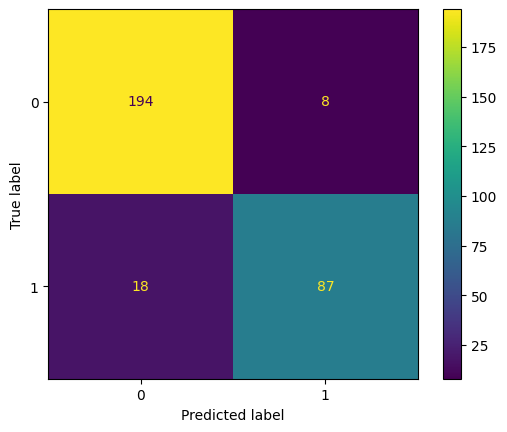

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Validação do modelo 

In [24]:
df3.head()

,link,metaforico,indice_noticia,paragrafos_resgatados,paragrafos_tratados_sw,paragrafos_tratados_sw_vetorizados
0,https://opiniao.estadao.com.br/noticias/artigo...,1,0,['Nunca tivemos lideranças governamentais tão ...,lideranças governamentais esquizofrenicamente ...,[[ 1.24453096e+00 1.80456701e+00 3.88217398e...
1,https://opiniao.estadao.com.br/noticias/artigo...,1,1,"['(13/4, A3) faz correta análise da deplorável...",correta análise deplorável conduta jair bolson...,[[ 3.82997599e+00 2.61315710e+00 2.64887299e...
2,https://opiniao.estadao.com.br/noticias/espaco...,1,2,['A esquizofrenia se faz presente no governo: ...,esquizofrenia presente governo caudatário cent...,[[ 3.10971797 -1.09312899 2.69877705 -3.15451...
3,https://cultura.estadao.com.br/noticias/litera...,1,3,"['""Durante meus dois anos\xa0em Berkeley, não\...",durante anos berkeley conheci americano sequer...,[[ 5.54485902e+00 3.73239404e+00 1.59974998e...
4,"https://cultura.estadao.com.br/noticias/geral,...",1,4,"['Contra elas, usamos as teias invisíveis da c...",usamos teias invisíveis casa resultado óbvia e...,[[ 0.54727099 0.45336103 0.42255901 -0.56468...


In [25]:
print("Dados de validação:")
print(df3.metaforico.value_counts(dropna = False))
print(" ")
print("Dados de validação em percentual: ")
print(df3.metaforico.value_counts(dropna = False, normalize = True))

Dados de validação:
0    71
1    32
Name: metaforico, dtype: int64
 
Dados de validação em percentual: 
0    0.68932
1    0.31068
Name: metaforico, dtype: float64


In [26]:
X_val = vetor3
y_val = df3[["metaforico"]]

In [27]:
y_predict_val = (model_cbow.predict(X_val) > 0.5).astype("int32")

4/4 [==============================] - 0s 3ms/step


In [28]:
y_pred_val = [x[0] for x in y_predict_val]

In [29]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        71
           1       0.84      0.84      0.84        32

    accuracy                           0.90       103
   macro avg       0.89      0.89      0.89       103
weighted avg       0.90      0.90      0.90       103



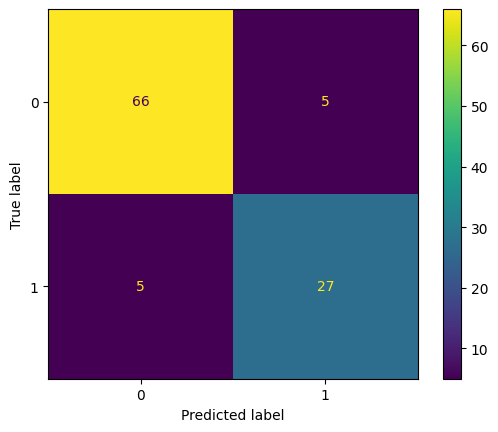

In [30]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val)

In [39]:
import dill as pickle



tf.saved_model.LoadOptions(
    allow_partial_checkpoint=False,
    experimental_io_device='/job:localhost',
    experimental_skip_checkpoint=False)

In [40]:
with open("modelo_teste.pkl", "wb") as f:
    pickle.dump(model_cbow, f)

INFO:tensorflow:Assets written to: ram://f2b2f85d-7379-4f1f-8684-b37eaafafbf7/assets


INFO:tensorflow:Assets written to: ram://f2b2f85d-7379-4f1f-8684-b37eaafafbf7/assets


In [41]:
with open("modelo_teste.pkl", "rb") as f:
    m = pickle.load(f)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://6a1c425b-167a-4e5b-ac02-63fe09e6e87f/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [44]:
tf.__version__

'2.9.2'

In [43]:
!pip install tensorflow 

# Aplicação do modelo para realizar previsões:

In [31]:
base_vetorizada = "s3_base_vetorizada_600"

pasta_entrada = "bases_aplicacao"
pasta_saida = "analises_de_resultados"


arquivo1 = "tratado_links_correio_do_povo_organizado_paragrafos_resgatados.csv"
arquivo2 = "tratado_links_estadao_resgatados.csv"
arquivo3 = "tratado_links_folha_sem_rotulo_resgatados.csv"

In [33]:
# # Seleciono o arquivo
arquivo = arquivo1

# # Leio e imprimo o tamanho
dt = pd.read_csv(f"{base_vetorizada}/{pasta_entrada}/{arquivo}")
print("tamanho = ", dt.shape)

# Leio o texto vetorizado
Xapp = np.load(f"{base_vetorizada}/{pasta_entrada}/{arquivo}.npy")

# Faço a predição
y_predict_app = (model_cbow.predict(Xapp) > 0.5).astype("int32")

# Formato a predição
y_pred_app = [x[0] for x in y_predict_app]

# Registro na base de dados
dt["metaforico_pred"] = y_pred_app
dt.to_csv(f"{pasta_saida}/base_aplicacao_resultado/rotulado_{arquivo}")

tamanho =  (210, 7)
7/7 [==============================] - 0s 4ms/step


In [36]:
dt1 = dt[["ano", "links", "nome", "paragrafos_resgatados", "paragrafos_tratados_sw", "metaforico_pred"]]
dt1["metaforico"] = dt1["metaforico_pred"].map({0:"nao", 1:"sim"})
dt1

c:\Users\r-omd\.conda\envs\tf-venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ano,links,nome,paragrafos_resgatados,paragrafos_tratados_sw,metaforico_pred,metaforico
0,2009,https://www.correiodopovo.com.br/not%C3%ADcias...,esquizofrenia,"['Em entrevista, a governadora considerou ""inc...",entrevista governadora considerou incoerente p...,1,sim
1,2010,https://www.correiodopovo.com.br/not%C3%ADcias...,esquizofrenia,['Dependentes químicos eram mantidos de forma ...,dependentes químicos eram mantidos irregular p...,0,nao
2,2010,https://www.correiodopovo.com.br/not%C3%ADcias...,esquizofrenia,['Dependentes químicos eram mantidos de forma ...,juizado infância juventude passo fundo norte c...,0,nao
3,2010,https://www.correiodopovo.com.br/not%C3%ADcias...,esquizofrenia,['Dependentes químicos eram mantidos de forma ...,encontraram pacientes sexos estavam adolescent...,0,nao
4,2010,https://www.correiodopovo.com.br/not%C3%ADcias...,esquizofrenia,['Os pacientes internados em uma clínica\xa0pa...,pacientes internados clínica recuperação depen...,0,nao
...,...,...,...,...,...,...,...
205,2010,https://www.correiodopovo.com.br/not%C3%ADcias...,esquizofrenicas,"['""O mesmo ato pode gerar quatro recursos dife...",ato gerar recursos diferentes pluralidade mere...,1,sim
206,2011,https://www.correiodopovo.com.br/blogs/juremir...,esquizofrenicas,['O CONFEF impôs normas absolutamente esquizof...,confef impôs normas absolutamente esquizofrêni...,1,sim
207,2013,https://www.correiodopovo.com.br/arteagenda/al...,esquizofrenicas,"['Elegante, cool, usando um modelito Cotton Cl...",elegante cool usando modelito cotton club bust...,1,sim
208,2016,https://www.correiodopovo.com.br/blogs/oscarbe...,esquizofrenicas,['Palavrinhas chaves nestes dias difíceis. Em ...,palavrinhas chaves nestes dias difíceis tempos...,1,sim


In [38]:
dt1.to_excel("analises_de_resultados/analises_bases_unidas/bases/base_final_correio_do_povo_completo.xlsx", index = False)